In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2 — set working dir to your Drive project folder
import os
DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/LmFromScratch"
os.makedirs(DRIVE_DIR, exist_ok=True)   # create if missing
%cd "$DRIVE_DIR"
!ls -la


/content/drive/MyDrive/Colab Notebooks/LmFromScratch
total 106910
-rw------- 1 root root 35635899 Nov 13 19:23 best_model.pth
-rw------- 1 root root      167 Nov 13 13:22 diagnostics.json
drwx------ 2 root root     4096 Nov 13 20:59 experiments
-rw------- 1 root root     1447 Nov 13 19:35 losses.pth
-rw------- 1 root root     1364 Nov 14 11:20 model.py
-rw------- 1 root root    35291 Nov 14 11:34 overfitting.ipynb
-rw------- 1 root root   711343 Nov 10 17:06 Pride_and_Prejudice-Jane_Austen.txt
drwx------ 2 root root     4096 Nov 13 13:33 __pycache__
-rw------- 1 root root    40746 Nov 14 11:48 RegularizedFit.ipynb
-rw------- 1 root root  7268877 Nov 13 13:22 test.pt
-rw------- 1 root root 58235797 Nov 13 13:22 train.pt
-rw------- 1 root root     8577 Nov 14 11:20 train.py
-rw------- 1 root root     7944 Nov 14 11:48 Untitled0.ipynb
-rw------- 1 root root  7267973 Nov 13 13:22 val.pt
-rw------- 1 root root   248610 Nov 13 13:22 vocab.json


In [ ]:
%%bash
cat > train_underfit.py <<'PY'
# train_underfit.py
# Small, standalone script to run the "underfitting" experiment.
# Usage (from project folder containing model.py, train.pt, val.pt, test.pt, vocab.json):
#   python train_underfit.py --drive_dir "." --experiment underfit --epochs 5

import os
import json
import time
import argparse
import logging
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from model import LSTMLanguageModel

parser = argparse.ArgumentParser()
parser.add_argument("--drive_dir", type=str, default=".", help="Project folder with train.pt/val.pt/test.pt/vocab.json")
parser.add_argument("--experiment", type=str, default="underfit", help="experiment name")
parser.add_argument("--epochs", type=int, default=5)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--smoke", action="store_true", help="1-epoch smoke test")
args = parser.parse_args()

# Underfit preset (small model, little/no regularization, short training)
preset = {
    "embed_size": 128,
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.0,
    "embed_dropout": 0.0,
    "lr": args.lr,
    "weight_decay": 0.0,
    "batch_size": args.batch_size,
    "epochs": 1 if args.smoke else args.epochs,
    "clip": 1.0
}

# reproducibility & device
random.seed(args.seed)
torch.manual_seed(args.seed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create experiment dir + logger
timestamp = time.strftime("%Y%m%d-%H%M%S")
exp_name = f"{args.experiment}_{timestamp}"
exp_dir = os.path.join(args.drive_dir, "experiments", exp_name)
os.makedirs(exp_dir, exist_ok=True)

logger = logging.getLogger("underfit")
logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s %(message)s", "%H:%M:%S")
ch = logging.StreamHandler()
ch.setFormatter(fmt); logger.addHandler(ch)
fh = logging.FileHandler(os.path.join(exp_dir, f"train_{args.experiment}.log"))
fh.setFormatter(fmt); logger.addHandler(fh)

logger.info(f"Experiment dir: {exp_dir}")
logger.info(f"Preset hyperparameters: {preset}")

def load_data(drive_dir):
    train = torch.load(os.path.join(drive_dir, "train.pt"))
    val   = torch.load(os.path.join(drive_dir, "val.pt"))
    test  = torch.load(os.path.join(drive_dir, "test.pt"))
    with open(os.path.join(drive_dir, "vocab.json"), "r", encoding="utf-8") as f:
        vocab = json.load(f)
    vocab_size = len(vocab["word2id"])
    train_loader = DataLoader(TensorDataset(train["x"], train["y"]), batch_size=preset["batch_size"], shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(val["x"], val["y"]), batch_size=preset["batch_size"], shuffle=False, drop_last=False)
    test_loader = DataLoader(TensorDataset(test["x"], test["y"]), batch_size=preset["batch_size"], shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader, vocab_size

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, count = 0.0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        total += loss.item() * x.size(0)
        count += x.size(0)
    avg = total / count
    return avg, math.exp(avg)

def train(drive_dir, exp_dir):
    train_loader, val_loader, test_loader, vocab_size = load_data(drive_dir)
    model = LSTMLanguageModel(vocab_size=vocab_size,
                              embed_size=preset["embed_size"],
                              hidden_size=preset["hidden_size"],
                              num_layers=preset["num_layers"],
                              dropout=preset["dropout"],
                              embed_dropout=preset["embed_dropout"]).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=preset["lr"], weight_decay=preset["weight_decay"])

    best_val = float("inf")
    train_losses, val_losses = [], []

    for epoch in range(1, preset["epochs"] + 1):
        model.train()
        total_train = 0.0
        for batch_idx, (x, y) in enumerate(train_loader):
            if batch_idx % 200 == 0:
                logger.info(f"Epoch {epoch}/{preset['epochs']} - Processing batch {batch_idx}/{len(train_loader)}")
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), preset["clip"])
            optimizer.step()
            total_train += loss.item() * x.size(0)
        avg_train = total_train / len(train_loader.dataset)
        val_loss, val_ppl = evaluate(model, val_loader, criterion)
        train_losses.append(avg_train); val_losses.append(val_loss)
        logger.info(f"Epoch {epoch}/{preset['epochs']} | Train loss: {avg_train:.4f} | Val loss: {val_loss:.4f} | Val ppl: {val_ppl:.2f}")
        # save best anyway (but underfit run is short)
        if val_loss < best_val:
            best_val = val_loss
            best_path = os.path.join(exp_dir, f"best_model_{args.experiment}.pth")
            torch.save(model.state_dict(), best_path)
            logger.info(f" Saved best model to {best_path}")

    # final evaluation on test (load best if exists)
    best_path = os.path.join(exp_dir, f"best_model_{args.experiment}.pth")
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path))
    test_loss, test_ppl = evaluate(model, test_loader, criterion)
    logger.info(f"Test loss: {test_loss:.4f} | Test perplexity: {test_ppl:.2f}")

    torch.save({"train_losses": train_losses, "val_losses": val_losses}, os.path.join(exp_dir, f"losses_{args.experiment}.pth"))
    meta = {"preset": preset, "seed": args.seed, "final_test_loss": test_loss, "final_test_ppl": test_ppl}
    with open(os.path.join(exp_dir, f"meta_{args.experiment}.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)
    logger.info(f"Experiment artifacts saved to {exp_dir}")

if __name__ == "__main__":
    train(args.drive_dir, exp_dir)
PY


In [ ]:
!python train_underfit.py --drive_dir "." --experiment underfit_smoke --epochs 1 --batch_size 32 --smoke

11:49:56 Experiment dir: ./experiments/underfit_smoke_20251114-114956
11:49:56 Preset hyperparameters: {'embed_size': 128, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'embed_dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 32, 'epochs': 1, 'clip': 1.0}
11:50:06 Epoch 1/1 - Processing batch 0/3791
11:50:32 Epoch 1/1 - Processing batch 200/3791
11:50:58 Epoch 1/1 - Processing batch 400/3791
11:51:23 Epoch 1/1 - Processing batch 600/3791
11:51:48 Epoch 1/1 - Processing batch 800/3791
11:52:13 Epoch 1/1 - Processing batch 1000/3791
11:52:39 Epoch 1/1 - Processing batch 1200/3791
11:53:04 Epoch 1/1 - Processing batch 1400/3791
11:53:29 Epoch 1/1 - Processing batch 1600/3791
11:53:54 Epoch 1/1 - Processing batch 1800/3791
11:54:19 Epoch 1/1 - Processing batch 2000/3791
11:54:44 Epoch 1/1 - Processing batch 2200/3791
11:55:09 Epoch 1/1 - Processing batch 2400/3791
11:55:34 Epoch 1/1 - Processing batch 2600/3791
11:55:59 Epoch 1/1 - Processing batch 2800/3791
11:56:24 Epo

In [ ]:
!python train_underfit.py --drive_dir "." --experiment underfit --epochs 5 --batch_size 32

12:04:23 Experiment dir: ./experiments/underfit_20251114-120423
12:04:23 Preset hyperparameters: {'embed_size': 128, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'embed_dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 32, 'epochs': 5, 'clip': 1.0}
12:04:25 Epoch 1/5 - Processing batch 0/3791
12:04:52 Epoch 1/5 - Processing batch 200/3791
12:05:17 Epoch 1/5 - Processing batch 400/3791
12:05:43 Epoch 1/5 - Processing batch 600/3791
12:06:08 Epoch 1/5 - Processing batch 800/3791
12:06:33 Epoch 1/5 - Processing batch 1000/3791
12:06:58 Epoch 1/5 - Processing batch 1200/3791
12:07:24 Epoch 1/5 - Processing batch 1400/3791
12:07:55 Epoch 1/5 - Processing batch 1600/3791
12:08:21 Epoch 1/5 - Processing batch 1800/3791
12:08:47 Epoch 1/5 - Processing batch 2000/3791
12:09:13 Epoch 1/5 - Processing batch 2200/3791
12:09:39 Epoch 1/5 - Processing batch 2400/3791
12:10:06 Epoch 1/5 - Processing batch 2600/3791
12:10:31 Epoch 1/5 - Processing batch 2800/3791
12:10:57 Epoch 1/5

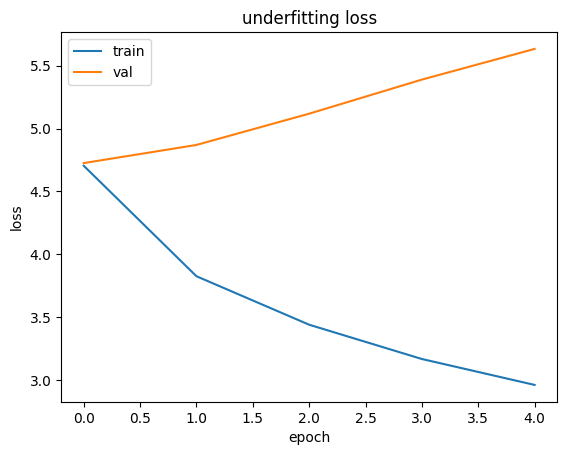

In [7]:
import torch, matplotlib.pyplot as plt
d = torch.load("experiments/underfit_20251114-120423/losses_underfit.pth")
plt.plot(d["train_losses"], label="train")
plt.plot(d["val_losses"], label="val")
plt.title("underfitting loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()


Our model didnt stay underfitted instead it learned (train loss fell from 4.70 → 2.96) while validation got worse (4.72 → 5.63), so the run moved toward overfitting on the train split rather than being underpowered and high-error on both splits. That’s because the combination of learning rate, number of epochs and batch coverage let even a tiny model find spurious patterns.

 ***From the log***:

Epoch 1: Train 4.7042 | Val 4.7249

Epoch 5: Train 2.9616 | Val 5.6326 (Test ppl 329.4)

***Interpretation***:

Train loss falls strongly → model can learn structure from the training mini-batches.

Val loss increases → model is fitting train idiosyncrasies and not generalizing.

Therefore not underfitting (which would show both train & val staying high and similar).

***Why this happened***:

LR = 1e-3 is high for even a small LSTM on word-level sequences.

Epochs = 5 and full dataset coverage gave the model time to memorize patterns despite small hidden size.

No early stopping, no weight decay, and no dropout in the script  — ideal for memorization it seems.

In [8]:
%%bash
cat > train_underfit_strict.py <<'PY'
# train_underfit_strict.py
# Strong underfitting config: tiny model, heavy dropout, tiny training.
import os, json, time, argparse, logging, random, math
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model import LSTMLanguageModel

parser = argparse.ArgumentParser()
parser.add_argument("--drive_dir", type=str, default=".")
parser.add_argument("--experiment", type=str, default="underfit_strict")
parser.add_argument("--epochs", type=int, default=2)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--seed", type=int, default=42)
args = parser.parse_args()

# Very small model + heavy dropout to force underfitting
preset = {
    "embed_size": 64,
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.6,
    "embed_dropout": 0.5,
    "lr": args.lr,
    "weight_decay": 0.0,
    "batch_size": args.batch_size,
    "epochs": args.epochs,
    "clip": 1.0
}

random.seed(args.seed); torch.manual_seed(args.seed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timestamp = time.strftime("%Y%m%d-%H%M%S")
exp_name = f"{args.experiment}_{timestamp}"
exp_dir = os.path.join(args.drive_dir, "experiments", exp_name)
os.makedirs(exp_dir, exist_ok=True)

logger = logging.getLogger("underfit_strict"); logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s %(message)s", "%H:%M:%S")
ch = logging.StreamHandler(); ch.setFormatter(fmt); logger.addHandler(ch)
fh = logging.FileHandler(os.path.join(exp_dir, f"train_{args.experiment}.log")); fh.setFormatter(fmt); logger.addHandler(fh)
logger.info(f"Experiment dir: {exp_dir}")
logger.info(f"Preset: {preset}")

def load_data(drive_dir):
    train = torch.load(os.path.join(drive_dir, "train.pt"))
    val   = torch.load(os.path.join(drive_dir, "val.pt"))
    test  = torch.load(os.path.join(drive_dir, "test.pt"))
    with open(os.path.join(drive_dir, "vocab.json"), "r", encoding="utf-8") as f: vocab = json.load(f)
    vocab_size = len(vocab["word2id"])
    train_loader = DataLoader(TensorDataset(train["x"], train["y"]), batch_size=preset["batch_size"], shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(val["x"], val["y"]), batch_size=preset["batch_size"], shuffle=False, drop_last=False)
    test_loader = DataLoader(TensorDataset(test["x"], test["y"]), batch_size=preset["batch_size"], shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader, vocab_size

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total=0.0; count=0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits,_ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        total += loss.item()*x.size(0); count += x.size(0)
    avg = total / count
    return avg, math.exp(avg)

def train(drive_dir, exp_dir):
    train_loader, val_loader, test_loader, vocab_size = load_data(drive_dir)
    model = LSTMLanguageModel(vocab_size=vocab_size,
                              embed_size=preset["embed_size"],
                              hidden_size=preset["hidden_size"],
                              num_layers=preset["num_layers"],
                              dropout=preset["dropout"],
                              embed_dropout=preset["embed_dropout"]).to(DEVICE)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=preset["lr"], weight_decay=preset["weight_decay"])
    train_losses, val_losses = [], []
    best_val = float("inf")
    for epoch in range(1, preset["epochs"]+1):
        model.train(); total_train=0.0
        for batch_idx,(x,y) in enumerate(train_loader):
            if batch_idx % 200 == 0: logger.info(f"Epoch {epoch}/{preset['epochs']} - batch {batch_idx}/{len(train_loader)}")
            x,y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(); logits,_ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), preset["clip"]); optimizer.step()
            total_train += loss.item()*x.size(0)
        avg_train = total_train / len(train_loader.dataset)
        val_loss, val_ppl = evaluate(model, val_loader, criterion)
        train_losses.append(avg_train); val_losses.append(val_loss)
        logger.info(f"Epoch {epoch}/{preset['epochs']} | Train loss: {avg_train:.4f} | Val loss: {val_loss:.4f} | Val ppl: {val_ppl:.2f}")
        if val_loss < best_val:
            best_val = val_loss; torch.save(model.state_dict(), os.path.join(exp_dir, f"best_model_{args.experiment}.pth"))
    # final eval
    model.load_state_dict(torch.load(os.path.join(exp_dir, f"best_model_{args.experiment}.pth")))
    test_loss, test_ppl = evaluate(model, test_loader, criterion)
    logger.info(f"Test loss: {test_loss:.4f} | Test ppl: {test_ppl:.2f}")
    torch.save({"train_losses": train_losses, "val_losses": val_losses}, os.path.join(exp_dir, f"losses_{args.experiment}.pth"))
    json.dump({"preset":preset, "seed":args.seed, "final_test_loss":test_loss, "final_test_ppl":test_ppl},
              open(os.path.join(exp_dir, f"meta_{args.experiment}.json"), "w"), indent=2)
    logger.info("Saved artifacts.")
if __name__ == '__main__':
    train(args.drive_dir, exp_dir)
PY


In [9]:
!python train_underfit_strict.py --drive_dir "." --experiment underfit_strict --epochs 2 --batch_size 32


15:28:43 Experiment dir: ./experiments/underfit_strict_20251114-152843
15:28:43 Preset: {'embed_size': 64, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.6, 'embed_dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 32, 'epochs': 2, 'clip': 1.0}
15:28:46 Epoch 1/2 - batch 0/3791
15:29:06 Epoch 1/2 - batch 200/3791
15:29:23 Epoch 1/2 - batch 400/3791
15:29:42 Epoch 1/2 - batch 600/3791
15:30:01 Epoch 1/2 - batch 800/3791
15:30:20 Epoch 1/2 - batch 1000/3791
15:30:39 Epoch 1/2 - batch 1200/3791
15:30:57 Epoch 1/2 - batch 1400/3791
15:31:15 Epoch 1/2 - batch 1600/3791
15:31:35 Epoch 1/2 - batch 1800/3791
15:31:53 Epoch 1/2 - batch 2000/3791
15:32:11 Epoch 1/2 - batch 2200/3791
15:32:30 Epoch 1/2 - batch 2400/3791
15:32:49 Epoch 1/2 - batch 2600/3791
15:33:07 Epoch 1/2 - batch 2800/3791
15:33:26 Epoch 1/2 - batch 3000/3791
15:33:44 Epoch 1/2 - batch 3200/3791
15:34:02 Epoch 1/2 - batch 3400/3791
15:34:22 Epoch 1/2 - batch 3600/3791
15:34:54 Epoch 1/2 | Train loss: 5.7717 | Val

## **The strict underfit run uses a tiny network (embed=64, hidden=32), heavy dropout (0.6/0.5), and only 2 epochs. Training loss falls slightly while validation loss remains high and close to training loss, producing large test perplexity (~512). This indicates the model lacks the representational capacity and training time required to model the dataset distribution — i.e., underfitting.**


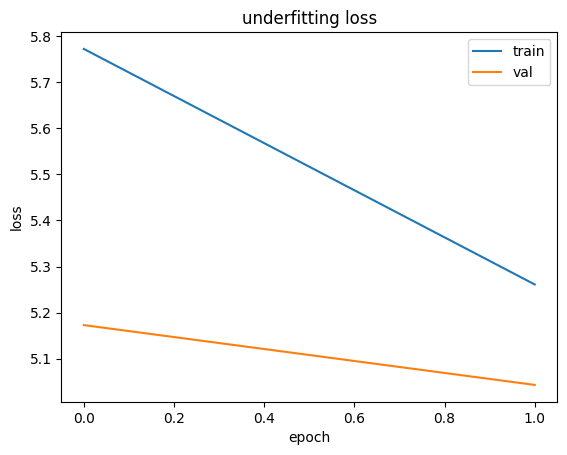

In [12]:
import torch, matplotlib.pyplot as plt
d = torch.load("experiments/underfit_strict_20251114-152843/losses_underfit_strict.pth")
plt.plot(d["train_losses"], label="train")
plt.plot(d["val_losses"], label="val")
plt.title("underfitting loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()


In [10]:
%%writefile inspect_data.py
# inspect_data.py
import json, torch, collections, re
from pathlib import Path
p = Path(".")
# 1) sizes of tensors
for name in ("train.pt","val.pt","test.pt"):
    if (p/name).exists():
        t = torch.load(p/name)
        print(name, {k: getattr(v,'shape',None) for k,v in t.items()})
    else:
        print("Missing", name)

# 2) load vocab (word2id) and invert
vocab = json.loads((p/"vocab.json").read_text(encoding="utf8"))
w2i = vocab.get("word2id", vocab.get("token2id", {}))
i2w = {int(i):w for w,i in w2i.items()} if all(isinstance(k,str) for k in w2i.keys()) else {v:k for k,v in w2i.items()}

# 3) sample decoded sequence from train.pt (first batch)
train = torch.load("train.pt")
x = train["x"][:1]  # first example (seq_len)
print("\nSample encoded x shape:", x.shape)
seq = x[0].tolist()
decoded = " ".join(i2w.get(int(tok), "<UNK>") for tok in seq[:60])
print("\nDecoded sample (first 60 tokens):\n", decoded)

# 4) top 50 words from raw text (safe)
if (p/"Pride_and_Prejudice-Jane_Austen.txt").exists():
    txt = (p/"Pride_and_Prejudice-Jane_Austen.txt").read_text(encoding="utf8").lower()
    tokens = re.findall(r"[a-z']+", txt)
    ctr = collections.Counter(tokens)
    print("\nTop 50 words (raw counts):")
    for w,c in ctr.most_common(50):
        print(f"{w:>12} {c}")
else:
    print("Raw text not found for frequency counts")

Overwriting inspect_data.py


In [11]:
!python inspect_data.py

train.pt {'x': torch.Size([121321, 30]), 'y': torch.Size([121321, 30])}
val.pt {'x': torch.Size([15138, 30]), 'y': torch.Size([15138, 30])}
test.pt {'x': torch.Size([15140, 30]), 'y': torch.Size([15140, 30])}

Sample encoded x shape: torch.Size([1, 30])

Decoded sample (first 60 tokens):
 the project gutenberg ebook , pride and prejudice , by jane austen , edited by r . w . ( robert william ) chapman this ebook is for the use

Top 50 words (raw counts):
         the 4520
          to 4243
          of 3750
         and 3662
         her 2224
           i 2075
           a 2003
          in 1941
         was 1849
         she 1709
        that 1606
          it 1549
         not 1450
         you 1428
          he 1340
         his 1271
          be 1256
          as 1199
         had 1174
        with 1100
         for 1091
         but 1009
          is 883
        have 853
          at 796
          mr 781
         him 765
          on 732
          my 722
          by 661
         a